## Setup a classification experiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# example of grid searching key hyperparameters for GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline


X = pd.read_csv('all_data/post_stool.csv', index_col = 0)
y = X["Response"]
print(y.value_counts())
X = X.drop("Response",1)

1    39
0    21
Name: Response, dtype: int64


In [253]:
species_cols = [col for col in X.columns if 'g__' in col]
X = X[species_cols]
X.shape

(60, 135)

In [164]:
response = []
for val in y:
    r = "Good" if val == 1 else "Poor"
    response.append(r)

In [159]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

print(np.median(ratio[y==1]))
print(np.median(ratio[y==0]))

px.bar(ratio,color=response)

0.4310417139067383
0.5876815317629878


In [87]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

def oob_rf_params(X,y):

    RANDOM_STATE = 123

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        (
            "RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(
                warm_start=True,
                oob_score=True,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(
                warm_start=True,
                max_features="log2",
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features=None",
            RandomForestClassifier(
                warm_start=True,
                max_features=None,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 500

    min_oob_error = 1

    j = 0
    sqrt_error = []
    log2_error = []
    none_error = []
    
    for label, clf in ensemble_clfs:
        
        errors = [sqrt_error,log2_error,none_error]
        
        for i in range(min_estimators, max_estimators + 1, 25):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            
            errors[j].append(oob_error)
            if oob_error < min_oob_error: 
                min_oob_error = oob_error
                best_estimators = i
                clf_best = str(clf[0])

            error_rate[label].append((i, oob_error))
        
        j += 1
        
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

    return min_oob_error, best_estimators, clf_best, errors

In [2]:
from scipy.stats import iqr
import matplotlib.ticker as ticker

def iqr_features(X,thresh):

    iqr_X = iqr(X, axis = 0)
        
#     ax = sns.histplot(iqr_X)
#     plt.xlim(0, 1)
#     plt.ylim(0, 15)
    
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
#     ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
#     plt.show()
    
#     print(np.mean(iqr_X))
    
    iqr_X = iqr_X.reshape(1,len(X.columns))

    iqr_df = pd.DataFrame(iqr_X, columns = X.columns)

    X_iqr = X.append(iqr_df)
    X_iqr = X_iqr.rename(index={0: "IQR"})
    
    #feats = ["s__Oscillibacter_sp_57_20"]

    #print(X_iqr.loc["IQR",feats])
        
    X_transposed = X_iqr.T
    new_X = X_transposed[X_transposed['IQR'] > thresh]
    X = new_X.drop('IQR', axis = 1).T
    
    X = new_X.drop('IQR', axis = 1).T
    
    return X, X.columns

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold
from math import floor
from tqdm import tqdm
import numpy as np
import warnings
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings(action='ignore')

seed = 1

folds = 21

kfold = RepeatedStratifiedKFold(n_splits=folds, n_repeats=10, random_state=seed)

clinical_scores = np.zeros((X.shape[0],10))

i = 0

feat_import = []

for train_index, test_index in tqdm(kfold.split(X, y), total=kfold.get_n_splits(), desc="k-fold"):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    X_train, features = iqr_features(X_train,0.4)
    print(X_train.shape)
    X_test = X_test.loc[:,features]
        
    #min_oob, trees, max_feats, errors = oob_rf_params(X_train,y_train)
    
#     if "sqrt" in max_feats: max_feats = "sqrt"
#     elif "log2" in max_feats: max_feats = "log2"
#     else: max_feats = None
        
#     print(min_oob, trees, max_feats)
        
    #model = RandomForestClassifier(n_estimators=trees,max_features=max_feats)
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    
    #lgb.plot_tree(model)
    #plt.show()
    
    for feat, imp in zip(features,model.feature_importances_):
        if imp > 0:
            print("Feature: " + str(feat) + " Importance: " + str(imp))
            feat_import.append([feat,imp])
    
    for pred,label in zip(model.predict_proba(X_test),test_index):
        clinical_scores[label][floor(i/folds)] = pred[1]
    
    for a, b in zip(model.predict_proba(X_test), y_test):
        print("Prediction: "+str(a)+" Real: "+str(b)+"\n")
    i += 1

k-fold:   0%|▎                                                                          | 1/210 [00:00<00:41,  5.07it/s]

(57, 107)
Feature: c__Betaproteobacteria Importance: 6
Feature: c__Coriobacteriia Importance: 9
Feature: f__Lachnospiraceae Importance: 7
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 6
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 3
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 11
Feature: s__Roseburia_hominis Importance: 4
Feature: g__Barnesiella Importance: 3
Feature: g__Gemmiger Importance: 6
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 8
Feature: s__Ruminococcus_bicirculans Importance: 3
Prediction: [0.27484898 0.72515102] Real: 0

Prediction: [0.46753587 0.53246413] Real: 1

Prediction: [0.25849887 0.74150113] Real: 1

(57, 106)


k-fold:   1%|█                                                                          | 3/210 [00:00<00:38,  5.40it/s]

Feature: c__Betaproteobacteria Importance: 8
Feature: c__Coriobacteriia Importance: 6
Feature: f__Lachnospiraceae Importance: 8
Feature: f__Eubacteriaceae Importance: 3
Feature: g__Clostridium Importance: 16
Feature: s__Bacteroides_uniformis Importance: 6
Feature: s__Bacteroides_dorei Importance: 6
Feature: s__Roseburia_hominis Importance: 6
Feature: s__Phascolarctobacterium_faecium Importance: 1
Feature: o__Coriobacteriales Importance: 3
Feature: f__Coriobacteriaceae Importance: 3
Feature: g__Gemmiger Importance: 2
Feature: g__Lachnospira Importance: 12
Feature: s__Coprococcus_comes Importance: 16
Feature: s__Collinsella_aerofaciens Importance: 3
Feature: s__Ruminococcus_bicirculans Importance: 4
Prediction: [0.41224932 0.58775068] Real: 1

Prediction: [0.63117224 0.36882776] Real: 1

Prediction: [0.11375971 0.88624029] Real: 0

(57, 104)
Feature: c__Betaproteobacteria Importance: 5
Feature: c__Coriobacteriia Importance: 11
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnosp

k-fold:   4%|███▏                                                                       | 9/210 [00:00<00:12, 16.00it/s]

Feature: g__Lachnospira Importance: 12
Feature: s__Coprococcus_comes Importance: 15
Feature: s__Roseburia_intestinalis Importance: 2
Prediction: [0.23602003 0.76397997] Real: 0

Prediction: [0.11566892 0.88433108] Real: 1

Prediction: [0.31123037 0.68876963] Real: 1

(57, 108)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 3
Feature: f__Clostridiaceae Importance: 9
Feature: f__Rikenellaceae Importance: 6
Feature: g__Agathobaculum Importance: 2
Feature: s__Bacteroides_uniformis Importance: 13
Feature: s__Bacteroides_dorei Importance: 10
Feature: s__Ruminococcus_bromii Importance: 4
Feature: s__Roseburia_hominis Importance: 4
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 12
Feature: s__Coprococcus_comes Importance: 10
Feature: s__Bacteroides_caccae Importance: 3
Feature: s__Ruminococcus_bicirculans Importance: 6
Prediction: [0.19113487 0.80886513] Real: 1

Prediction: [0.32598431 0.67

k-fold:   8%|█████▉                                                                    | 17/210 [00:01<00:07, 25.58it/s]

Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 5
Feature: o__Coriobacteriales Importance: 1
Feature: g__Barnesiella Importance: 1
Feature: g__Gemmiger Importance: 3
Feature: g__Lachnospira Importance: 11
Feature: s__Coprococcus_comes Importance: 14
Prediction: [0.23491746 0.76508254] Real: 1

Prediction: [0.26475294 0.73524706] Real: 1

Prediction: [0.68000801 0.31999199] Real: 0

(57, 104)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 8
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 11
Feature: g__Agathobaculum Importance: 1
Feature: s__Bacteroides_uniformis Importance: 14
Feature: s__Bacteroides_dorei Importance: 7
Feature: o__Coriobacteriales Importance: 4
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 16
Feature: s__Collinsella_aerofaciens Importance: 2

k-fold:  10%|███████▍                                                                  | 21/210 [00:01<00:06, 27.65it/s]

Prediction: [0.22618075 0.77381925] Real: 0

Prediction: [0.38161199 0.61838801] Real: 1

Prediction: [0.05935318 0.94064682] Real: 1

(58, 105)
Feature: c__Betaproteobacteria Importance: 6
Feature: c__Coriobacteriia Importance: 8
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 1
Feature: f__Clostridiaceae Importance: 10
Feature: f__Rikenellaceae Importance: 3
Feature: g__Clostridium Importance: 2
Feature: g__Phascolarctobacterium Importance: 1
Feature: g__Agathobaculum Importance: 2
Feature: g__Ruminococcaceae_unclassified Importance: 2
Feature: s__Bacteroides_uniformis Importance: 13
Feature: s__Bacteroides_dorei Importance: 10
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 2
Feature: g__Barnesiella Importance: 4
Feature: g__Gemmiger Importance: 4
Feature: g__Lachnospira Importance: 17
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Collinsella_aerofaciens Importance: 1
Feature: s__Bacteroides_caccae I

k-fold:  14%|██████████▏                                                               | 29/210 [00:01<00:05, 31.80it/s]

Prediction: [0.66924865 0.33075135] Real: 0

Prediction: [0.02974585 0.97025415] Real: 1

Prediction: [0.28448196 0.71551804] Real: 1

(57, 106)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 9
Feature: f__Lachnospiraceae Importance: 12
Feature: g__Clostridium Importance: 15
Feature: g__Phascolarctobacterium Importance: 4
Feature: s__Bacteroides_uniformis Importance: 5
Feature: s__Bacteroides_dorei Importance: 5
Feature: s__Roseburia_hominis Importance: 6
Feature: o__Coriobacteriales Importance: 2
Feature: f__Coriobacteriaceae Importance: 4
Feature: g__Barnesiella Importance: 5
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Collinsella_aerofaciens Importance: 5
Feature: s__Bacteroides_stercoris Importance: 1
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.06473832 0.93526168] Real: 0

Prediction: [0.77630831 0.22369169] Real: 1

Prediction: [0.84016323 0.15983677] Real: 1

(57, 107)
Fe

k-fold:  18%|█████████████                                                             | 37/210 [00:01<00:05, 31.82it/s]

Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 16
Feature: f__Lachnospiraceae Importance: 7
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 3
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 2
Feature: g__Ruminococcaceae_unclassified Importance: 1
Feature: s__Bacteroides_uniformis Importance: 14
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Roseburia_hominis Importance: 9
Feature: s__Alistipes_finegoldii Importance: 1
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Bacteroides_caccae Importance: 1
Prediction: [0.34871135 0.65128865] Real: 1

Prediction: [0.02477977 0.97522023] Real: 1

Prediction: [0.35948836 0.64051164] Real: 0

(57, 105)
Feature: p__Proteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 11
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Clostridiaceae Importance: 14
Feature: f__Rikenellaceae Impor

k-fold:  21%|███████████████▊                                                          | 45/210 [00:01<00:05, 32.42it/s]

Prediction: [0.46935793 0.53064207] Real: 0

Prediction: [0.04522129 0.95477871] Real: 1

Prediction: [0.36698851 0.63301149] Real: 1

(58, 104)
Feature: c__Coriobacteriia Importance: 9
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Clostridiaceae Importance: 8
Feature: f__Rikenellaceae Importance: 11
Feature: g__Clostridium Importance: 3
Feature: g__Agathobaculum Importance: 1
Feature: g__Faecalibacterium Importance: 1
Feature: s__Bacteroides_uniformis Importance: 16
Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 2
Feature: o__Coriobacteriales Importance: 5
Feature: g__Lachnospira Importance: 13
Feature: s__Bacteroides_massiliensis Importance: 1
Feature: s__Coprococcus_comes Importance: 17
Feature: s__Bacteroides_caccae Importance: 1
Prediction: [0.23596698 0.76403302] Real: 0

Prediction: [0.32031168 0.67968832] Real: 1

(58, 107)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriob

k-fold:  23%|█████████████████▎                                                        | 49/210 [00:02<00:05, 31.69it/s]

Feature: c__Coriobacteriia Importance: 13
Feature: f__Lachnospiraceae Importance: 6
Feature: f__Clostridiaceae Importance: 11
Feature: g__Clostridium Importance: 1
Feature: s__Bacteroides_uniformis Importance: 15
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 6
Feature: f__Barnesiellaceae Importance: 2
Feature: g__Barnesiella Importance: 3
Feature: g__Gemmiger Importance: 4
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.50999921 0.49000079] Real: 0

Prediction: [0.13262671 0.86737329] Real: 1

Prediction: [0.14073701 0.85926299] Real: 1

(57, 106)
Feature: c__Betaproteobacteria Importance: 7
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Clostridiaceae Importance: 9
Feature: f__Rikenellaceae Importance: 4
Feature: g__Clostridium Importance: 2
Feature: g__

k-fold:  27%|████████████████████                                                      | 57/210 [00:02<00:04, 31.11it/s]

(57, 106)
Feature: c__Coriobacteriia Importance: 10
Feature: f__Clostridiaceae Importance: 10
Feature: f__Rikenellaceae Importance: 5
Feature: g__Clostridium Importance: 2
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 5
Feature: g__Faecalibacterium Importance: 5
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 9
Feature: s__Roseburia_hominis Importance: 2
Feature: g__Barnesiella Importance: 6
Feature: g__Gemmiger Importance: 6
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 11
Feature: s__Ruminococcus_bicirculans Importance: 4
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.45232804 0.54767196] Real: 1

Prediction: [0.70716441 0.29283559] Real: 1

Prediction: [0.34582353 0.65417647] Real: 0

(57, 105)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 11
Feature: f__Bacteroidaceae Importance: 1
Feature: f__Clostridiaceae Importance: 

k-fold:  31%|██████████████████████▉                                                   | 65/210 [00:02<00:04, 30.47it/s]

Feature: c__Betaproteobacteria Importance: 5
Feature: c__Coriobacteriia Importance: 7
Feature: f__Lachnospiraceae Importance: 4
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 6
Feature: g__Clostridium Importance: 1
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 2
Feature: g__Faecalibacterium Importance: 1
Feature: s__Bacteroides_uniformis Importance: 15
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Roseburia_inulinivorans Importance: 2
Feature: s__Ruminococcus_bromii Importance: 4
Feature: s__Roseburia_hominis Importance: 5
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Bifidobacterium_longum Importance: 5
Prediction: [0.55384692 0.44615308] Real: 1

Prediction: [0.32604103 0.67395897] Real: 1

Prediction: [0.78923104 0.21076896] Real: 0

(58, 107)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 12
Feature: f__Lachnospiraceae Impo

k-fold:  33%|████████████████████████▎                                                 | 69/210 [00:02<00:04, 30.22it/s]

Feature: c__Betaproteobacteria Importance: 2
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 7
Feature: f__Clostridiaceae Importance: 12
Feature: g__Clostridium Importance: 1
Feature: g__Blautia Importance: 1
Feature: s__Bacteroides_uniformis Importance: 10
Feature: s__Bacteroides_dorei Importance: 13
Feature: s__Parabacteroides_merdae Importance: 1
Feature: s__Roseburia_hominis Importance: 4
Feature: o__Coriobacteriales Importance: 3
Feature: f__Coriobacteriaceae Importance: 1
Feature: g__Barnesiella Importance: 1
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 13
Feature: s__Bacteroides_massiliensis Importance: 5
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.20928185 0.79071815] Real: 1

Prediction: [0.77273665 0.22726335] Real: 1

Prediction: [0.46860379 0.53139621] Real: 0

(57, 106)
Feature: c__Betaproteobacteria Impo

k-fold:  37%|███████████████████████████▏                                              | 77/210 [00:02<00:04, 32.95it/s]

Feature: c__Betaproteobacteria Importance: 2
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 2
Feature: f__Clostridiaceae Importance: 9
Feature: f__Rikenellaceae Importance: 2
Feature: f__Eubacteriaceae Importance: 1
Feature: g__Ruminococcaceae_unclassified Importance: 3
Feature: s__Bacteroides_uniformis Importance: 10
Feature: s__Bacteroides_dorei Importance: 13
Feature: s__Roseburia_inulinivorans Importance: 1
Feature: s__Ruminococcus_bromii Importance: 7
Feature: s__Roseburia_hominis Importance: 1
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 11
Feature: s__Bacteroides_massiliensis Importance: 2
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Ruminococcus_bicirculans Importance: 7
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.32720599 0.67279401] Real: 0

Prediction: [0.24914819 0.75085181] Real: 1

Prediction: [0.15699372 0.84300628] Real: 1

(57, 105)
Feature: p__Proteobacteria Importance: 3
Feat

k-fold:  40%|█████████████████████████████▉                                            | 85/210 [00:03<00:03, 32.00it/s]

Feature: c__Betaproteobacteria Importance: 7
Feature: c__Coriobacteriia Importance: 6
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 1
Feature: f__Clostridiaceae Importance: 13
Feature: f__Rikenellaceae Importance: 10
Feature: g__Agathobaculum Importance: 1
Feature: s__Bacteroides_uniformis Importance: 10
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Ruminococcus_bromii Importance: 5
Feature: s__Roseburia_hominis Importance: 2
Feature: s__Alistipes_finegoldii Importance: 3
Feature: o__Coriobacteriales Importance: 2
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Ruminococcus_bicirculans Importance: 4
Feature: s__Bifidobacterium_longum Importance: 2
Prediction: [0.32501899 0.67498101] Real: 1

Prediction: [0.17486944 0.82513056] Real: 1

Prediction: [0.46993516 0.53006484] Real: 0

(57, 107)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Clostri

k-fold:  45%|█████████████████████████████████                                         | 94/210 [00:03<00:03, 34.74it/s]

Feature: c__Betaproteobacteria Importance: 1
Feature: c__Gammaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 10
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 2
Feature: f__Clostridiaceae Importance: 16
Feature: g__Phascolarctobacterium Importance: 1
Feature: g__Faecalibacterium Importance: 5
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 12
Feature: s__Firmicutes_bacterium_CAG_83 Importance: 3
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 3
Feature: s__Alistipes_finegoldii Importance: 2
Feature: o__Coriobacteriales Importance: 3
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 9
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Collinsella_aerofaciens Importance: 1
Prediction: [0.13549032 0.86450968] Real: 0

Prediction: [0.11528336 0.88471664] Real: 1

Prediction: [0.09341649 0.90658351] Real: 1

(57, 105)
Feature: c

k-fold:  47%|██████████████████████████████████▌                                       | 98/210 [00:03<00:03, 32.97it/s]

Feature: c__Betaproteobacteria Importance: 7
Feature: c__Coriobacteriia Importance: 11
Feature: f__Lachnospiraceae Importance: 2
Feature: f__Clostridiaceae Importance: 15
Feature: f__Rikenellaceae Importance: 3
Feature: g__Agathobaculum Importance: 5
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 6
Feature: s__Roseburia_hominis Importance: 5
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Bacteroides_caccae Importance: 1
Feature: s__Ruminococcus_bicirculans Importance: 5
Feature: s__Bifidobacterium_longum Importance: 1
Prediction: [0.37253814 0.62746186] Real: 1

Prediction: [0.45660852 0.54339148] Real: 1

Prediction: [0.49557121 0.50442879] Real: 0

(57, 106)
Feature: c__Negativicutes Importance: 1
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 8
Feature: f__Lachnospiraceae Importance: 1
Feature: f__Clostridiaceae Importan

k-fold:  50%|████████████████████████████████████▊                                    | 106/210 [00:03<00:03, 31.71it/s]

Feature: c__Betaproteobacteria Importance: 3
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 11
Feature: f__Lachnospiraceae Importance: 9
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 5
Feature: g__Clostridium Importance: 1
Feature: g__Ruminococcus Importance: 1
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 3
Feature: o__Coriobacteriales Importance: 2
Feature: g__Lachnospira Importance: 13
Feature: s__Bacteroides_massiliensis Importance: 2
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Collinsella_aerofaciens Importance: 1
Feature: s__Bifidobacterium_longum Importance: 1
Prediction: [0.44857947 0.55142053] Real: 1

Prediction: [0.19956442 0.80043558] Real: 1

Prediction: [0.61620087 0.38379913] Real: 0

(58, 106)
Feature: c__Betaproteobacteria Importance: 2
Feature: c__Cori

k-fold:  55%|███████████████████████████████████████▉                                 | 115/210 [00:04<00:02, 32.94it/s]

Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 3
Feature: f__Clostridiaceae Importance: 7
Feature: f__Rikenellaceae Importance: 6
Feature: g__Clostridium Importance: 4
Feature: g__Agathobaculum Importance: 5
Feature: s__Bacteroides_uniformis Importance: 13
Feature: s__Bacteroides_dorei Importance: 9
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 3
Feature: o__Coriobacteriales Importance: 2
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 15
Feature: s__Coprococcus_comes Importance: 12
Feature: s__Bacteroides_caccae Importance: 2
Feature: s__Ruminococcus_bicirculans Importance: 6
Prediction: [0.29487903 0.70512097] Real: 1

Prediction: [0.61796822 0.38203178] Real: 0

Prediction: [0.23012309 0.76987691] Real: 1

(57, 108)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Gammaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importan

k-fold:  59%|██████████████████████████████████████████▊                              | 123/210 [00:04<00:02, 33.81it/s]

Feature: p__Proteobacteria Importance: 4
Feature: p__Actinobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 4
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 2
Feature: g__Agathobaculum Importance: 2
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 13
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 1
Feature: s__Alistipes_finegoldii Importance: 4
Feature: g__Gemmiger Importance: 2
Feature: g__Lachnospira Importance: 16
Feature: s__Coprococcus_comes Importance: 15
Prediction: [0.37044665 0.62955335] Real: 1

Prediction: [0.01753197 0.98246803] Real: 1

Prediction: [0.19271788 0.80728212] Real: 0

(57, 106)
Feature: c__Betaproteobacteria Importance: 7
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 10
Feature: f__Clostridiaceae Importance: 13

k-fold:  60%|████████████████████████████████████████████▏                            | 127/210 [00:04<00:02, 33.27it/s]

Feature: c__Betaproteobacteria Importance: 5
Feature: c__Coriobacteriia Importance: 8
Feature: f__Bacteroidaceae Importance: 1
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 5
Feature: g__Clostridium Importance: 1
Feature: g__Agathobaculum Importance: 4
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 2
Feature: g__Barnesiella Importance: 1
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 11
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Bacteroides_caccae Importance: 2
Feature: s__Ruminococcus_bicirculans Importance: 7
Prediction: [0.12184878 0.87815122] Real: 1

Prediction: [0.64004215 0.35995785] Real: 0

(58, 105)
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 9
Fea

k-fold:  64%|██████████████████████████████████████████████▉                          | 135/210 [00:04<00:02, 30.49it/s]

Prediction: [0.14528977 0.85471023] Real: 1

Prediction: [0.12818502 0.87181498] Real: 1

Prediction: [0.49506614 0.50493386] Real: 0

(57, 104)
Feature: c__Betaproteobacteria Importance: 5
Feature: c__Coriobacteriia Importance: 14
Feature: f__Lachnospiraceae Importance: 6
Feature: f__Clostridiaceae Importance: 10
Feature: f__Rikenellaceae Importance: 8
Feature: g__Roseburia Importance: 2
Feature: g__Clostridium Importance: 3
Feature: s__Bacteroides_uniformis Importance: 13
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Roseburia_inulinivorans Importance: 1
Feature: s__Roseburia_hominis Importance: 1
Feature: s__Alistipes_finegoldii Importance: 2
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 14
Prediction: [0.24254348 0.75745652] Real: 1

Prediction: [0.36605146 0.63394854] Real: 1

Prediction: [0.50995757 0.49004243] Real: 0

(57, 110)
Feature: c__Negativicutes Importance: 2
Feature: c__Betaproteobacteria I

k-fold:  66%|████████████████████████████████████████████████▎                        | 139/210 [00:04<00:02, 29.34it/s]

(57, 105)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 11
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Clostridiaceae Importance: 13
Feature: f__Rikenellaceae Importance: 9
Feature: g__Agathobaculum Importance: 3
Feature: g__Ruminococcaceae_unclassified Importance: 1
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 4
Feature: f__Coriobacteriaceae Importance: 1
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Roseburia_intestinalis Importance: 1
Feature: s__Bacteroides_caccae Importance: 2
Prediction: [0.28969114 0.71030886] Real: 0

Prediction: [0.09740157 0.90259843] Real: 1

Prediction: [0.04206021 0.95793979] Real: 1

(57, 108)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Gammaproteobacteria Importance: 2
Feature: c__Coriobacteriia Importance: 9
Featu

k-fold:  69%|██████████████████████████████████████████████████▍                      | 145/210 [00:05<00:02, 27.03it/s]

Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 11
Feature: f__Lachnospiraceae Importance: 4
Feature: f__Clostridiaceae Importance: 14
Feature: f__Rikenellaceae Importance: 2
Feature: g__Agathobaculum Importance: 5
Feature: g__Faecalibacterium Importance: 2
Feature: s__Bacteroides_uniformis Importance: 15
Feature: s__Bacteroides_dorei Importance: 10
Feature: s__Roseburia_inulinivorans Importance: 2
Feature: s__Ruminococcus_bromii Importance: 4
Feature: s__Roseburia_hominis Importance: 3
Feature: s__Alistipes_finegoldii Importance: 4
Feature: g__Lachnospira Importance: 8
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Bifidobacterium_longum Importance: 1
Prediction: [0.18948592 0.81051408] Real: 1

Prediction: [0.49116858 0.50883142] Real: 1

Prediction: [0.28577962 0.71422038] Real: 0

(57, 105)
Feature: p__Firmicutes Importance: 1
Feature: c__Negativicutes Importance: 1
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacterii

k-fold:  73%|█████████████████████████████████████████████████████▏                   | 153/210 [00:05<00:01, 29.68it/s]

(57, 105)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Gammaproteobacteria Importance: 6
Feature: c__Coriobacteriia Importance: 12
Feature: f__Bacteroidaceae Importance: 3
Feature: f__Lachnospiraceae Importance: 1
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 2
Feature: g__Clostridium Importance: 8
Feature: g__Phascolarctobacterium Importance: 1
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 1
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 11
Feature: s__Roseburia_hominis Importance: 5
Feature: s__Alistipes_finegoldii Importance: 2
Feature: o__Coriobacteriales Importance: 1
Feature: g__Lachnospira Importance: 8
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Bifidobacterium_longum Importance: 3
Prediction: [0.12709149 0.87290851] Real: 0

Prediction: [0.69327316 0.30672684] Real: 1

Prediction: [0.4582513 0.5417487] Real: 1

(57, 107)
Feature: c__Betaproteoba

k-fold:  74%|██████████████████████████████████████████████████████▏                  | 156/210 [00:05<00:01, 29.21it/s]

Feature: s__Bacteroides_dorei Importance: 10
Feature: s__Ruminococcus_bromii Importance: 2
Feature: s__Roseburia_hominis Importance: 5
Feature: s__Alistipes_finegoldii Importance: 3
Feature: g__Barnesiella Importance: 3
Feature: g__Gemmiger Importance: 6
Feature: g__Lachnospira Importance: 9
Feature: s__Bacteroides_massiliensis Importance: 2
Feature: s__Coprococcus_comes Importance: 11
Prediction: [0.24578412 0.75421588] Real: 1

Prediction: [0.25349588 0.74650412] Real: 0

Prediction: [0.8773125 0.1226875] Real: 1

(57, 105)
Feature: c__Betaproteobacteria Importance: 7
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 6
Feature: g__Clostridium Importance: 3
Feature: g__Agathobaculum Importance: 5
Feature: s__Bacteroides_uniformis Importance: 10
Feature: s__Bacteroides_dorei Importance: 9
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance

k-fold:  78%|█████████████████████████████████████████████████████████                | 164/210 [00:05<00:01, 31.71it/s]

Prediction: [0.04626645 0.95373355] Real: 1

Prediction: [0.37306903 0.62693097] Real: 0

Prediction: [0.07819193 0.92180807] Real: 1

(57, 107)
Feature: c__Betaproteobacteria Importance: 5
Feature: c__Gammaproteobacteria Importance: 6
Feature: c__Coriobacteriia Importance: 14
Feature: f__Lachnospiraceae Importance: 3
Feature: f__Clostridiaceae Importance: 11
Feature: g__Agathobaculum Importance: 4
Feature: g__Faecalibacterium Importance: 1
Feature: s__Bacteroides_uniformis Importance: 8
Feature: s__Bacteroides_dorei Importance: 7
Feature: s__Roseburia_hominis Importance: 1
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 8
Feature: s__Coprococcus_comes Importance: 11
Feature: s__Bacteroides_caccae Importance: 5
Feature: s__Ruminococcus_bicirculans Importance: 11
Prediction: [0.11400244 0.88599756] Real: 1

Prediction: [0.29896599 0.70103401] Real: 0

Prediction: [0.31547978 0.68452022] Real: 1

(57, 109)
Feature: c__Betaproteobacteria Importance: 7
Feature: c__Co

k-fold:  82%|███████████████████████████████████████████████████████████▊             | 172/210 [00:05<00:01, 30.36it/s]

(58, 107)
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 9
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellaceae Importance: 6
Feature: g__Clostridium Importance: 2
Feature: g__Agathobaculum Importance: 1
Feature: g__Ruminococcaceae_unclassified Importance: 2
Feature: s__Bacteroides_uniformis Importance: 14
Feature: s__Bacteroides_dorei Importance: 11
Feature: s__Ruminococcus_bromii Importance: 2
Feature: s__Eubacterium_siraeum Importance: 1
Feature: s__Roseburia_hominis Importance: 2
Feature: g__Gemmiger Importance: 5
Feature: g__Lachnospira Importance: 17
Feature: s__Bacteroides_massiliensis Importance: 1
Feature: s__Coprococcus_comes Importance: 11
Feature: s__Ruminococcus_bicirculans Importance: 9
Prediction: [0.34035041 0.65964959] Real: 0

Prediction: [0.12729605 0.87270395] Real: 1

(58, 106)
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Gammaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 8
Featur

k-fold:  84%|█████████████████████████████████████████████████████████████▏           | 176/210 [00:06<00:01, 29.59it/s]

Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 13
Feature: f__Lachnospiraceae Importance: 2
Feature: f__Clostridiaceae Importance: 14
Feature: f__Odoribacteraceae Importance: 1
Feature: g__Clostridium Importance: 4
Feature: g__Agathobaculum Importance: 1
Feature: s__Bacteroides_uniformis Importance: 15
Feature: s__Bacteroides_dorei Importance: 11
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 1
Feature: s__Alistipes_finegoldii Importance: 3
Feature: o__Coriobacteriales Importance: 3
Feature: f__Coriobacteriaceae Importance: 2
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 13
Feature: s__Coprococcus_comes Importance: 14
Prediction: [0.35809394 0.64190606] Real: 1

Prediction: [0.17480265 0.82519735] Real: 0

Prediction: [0.47220908 0.52779092] Real: 1

(57, 106)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 11
Feature: f__Lachnospiraceae Importance:

k-fold:  87%|███████████████████████████████████████████████████████████████▎         | 182/210 [00:06<00:01, 27.10it/s]

Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 10
Feature: f__Bacteroidaceae Importance: 3
Feature: f__Lachnospiraceae Importance: 4
Feature: f__Clostridiaceae Importance: 14
Feature: f__Rikenellaceae Importance: 5
Feature: g__Phascolarctobacterium Importance: 2
Feature: g__Ruminococcus Importance: 1
Feature: g__Agathobaculum Importance: 2
Feature: g__Ruminococcaceae_unclassified Importance: 3
Feature: g__Faecalibacterium Importance: 5
Feature: s__Bacteroides_uniformis Importance: 10
Feature: s__Bacteroides_dorei Importance: 9
Feature: s__Ruminococcus_bromii Importance: 3
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 15
Prediction: [0.34406331 0.65593669] Real: 0

Prediction: [0.46249348 0.53750652] Real: 1

Prediction: [0.1728498 0.8271502] Real: 1

(57, 108)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 8
Feature: f__Lachnospiraceae Importance: 6
Feature: f__Clostridiaceae Im

k-fold:  90%|██████████████████████████████████████████████████████████████████       | 190/210 [00:06<00:00, 30.36it/s]

Feature: c__Betaproteobacteria Importance: 3
Feature: c__Coriobacteriia Importance: 11
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 3
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 6
Feature: g__Clostridium Importance: 4
Feature: g__Ruminococcaceae_unclassified Importance: 1
Feature: s__Bacteroides_uniformis Importance: 13
Feature: s__Bacteroides_dorei Importance: 11
Feature: s__Ruminococcus_bromii Importance: 1
Feature: s__Roseburia_hominis Importance: 4
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 15
Feature: s__Bacteroides_massiliensis Importance: 3
Feature: s__Coprococcus_comes Importance: 15
Prediction: [0.03412251 0.96587749] Real: 1

Prediction: [0.09981306 0.90018694] Real: 1

Prediction: [0.42260516 0.57739484] Real: 0

(57, 106)
Feature: c__Betaproteobacteria Importance: 4
Feature: c__Coriobacteriia Importance: 9
Feature: f__Lachnospiraceae Importance: 2
Feature: f__Clostridiaceae I

k-fold:  92%|███████████████████████████████████████████████████████████████████▍     | 194/210 [00:06<00:00, 30.49it/s]

Prediction: [0.10478802 0.89521198] Real: 1

Prediction: [0.34108413 0.65891587] Real: 1

Prediction: [0.41283949 0.58716051] Real: 0

(57, 106)
Feature: c__Betaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 12
Feature: f__Bacteroidaceae Importance: 2
Feature: f__Lachnospiraceae Importance: 3
Feature: f__Clostridiaceae Importance: 10
Feature: g__Agathobaculum Importance: 2
Feature: s__Bacteroides_uniformis Importance: 11
Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 2
Feature: s__Roseburia_hominis Importance: 3
Feature: g__Barnesiella Importance: 5
Feature: g__Gemmiger Importance: 8
Feature: g__Lachnospira Importance: 10
Feature: s__Coprococcus_comes Importance: 14
Feature: s__Bacteroides_caccae Importance: 1
Feature: s__Ruminococcus_bicirculans Importance: 8
Prediction: [0.51108347 0.48891653] Real: 0

Prediction: [0.15030786 0.84969214] Real: 1

Prediction: [0.24639919 0.75360081] Real: 1

(57, 107)
Feature: c__Betaproteo

k-fold:  96%|██████████████████████████████████████████████████████████████████████▏  | 202/210 [00:06<00:00, 29.84it/s]

Prediction: [0.32049294 0.67950706] Real: 1

Prediction: [0.29677222 0.70322778] Real: 0

Prediction: [0.08485414 0.91514586] Real: 1

(57, 105)
Feature: c__Betaproteobacteria Importance: 3
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 12
Feature: f__Lachnospiraceae Importance: 5
Feature: f__Rikenellaceae Importance: 7
Feature: g__Clostridium Importance: 13
Feature: g__Agathobaculum Importance: 3
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 8
Feature: s__Ruminococcus_bromii Importance: 3
Feature: s__Roseburia_hominis Importance: 3
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 11
Feature: s__Coprococcus_comes Importance: 11
Feature: s__Roseburia_intestinalis Importance: 1
Feature: s__Bacteroides_caccae Importance: 5
Feature: s__Bifidobacterium_longum Importance: 1
Prediction: [0.29792326 0.70207674] Real: 0

Prediction: [0.17468883 0.82531117] Real: 1

Prediction: [0.55428753 0.

k-fold: 100%|█████████████████████████████████████████████████████████████████████████| 210/210 [00:07<00:00, 29.06it/s]

Feature: c__Betaproteobacteria Importance: 2
Feature: c__Coriobacteriia Importance: 11
Feature: f__Clostridiaceae Importance: 12
Feature: f__Rikenellaceae Importance: 4
Feature: g__Agathobaculum Importance: 4
Feature: s__Bacteroides_uniformis Importance: 12
Feature: s__Bacteroides_dorei Importance: 10
Feature: s__Ruminococcus_bromii Importance: 2
Feature: s__Roseburia_hominis Importance: 4
Feature: g__Gemmiger Importance: 1
Feature: g__Lachnospira Importance: 17
Feature: s__Bacteroides_massiliensis Importance: 2
Feature: s__Coprococcus_comes Importance: 13
Feature: s__Ruminococcus_bicirculans Importance: 6
Prediction: [0.29823084 0.70176916] Real: 1

Prediction: [0.02194394 0.97805606] Real: 1

Prediction: [0.32253781 0.67746219] Real: 0

(57, 105)
Feature: c__Betaproteobacteria Importance: 7
Feature: c__Gammaproteobacteria Importance: 1
Feature: c__Coriobacteriia Importance: 10
Feature: f__Lachnospiraceae Importance: 4
Feature: f__Clostridiaceae Importance: 11
Feature: f__Rikenellacea

In [116]:
feature_df = pd.DataFrame(np.row_stack(feat_import))
feature_df[1] = feature_df[1].astype(float)
feature_df_max_import = feature_df.groupby(0).sum()
max_sum = np.argpartition(feature_df_max_import[1], -10)[-10:].to_list()

arr = []
for val in max_sum:
    X_good = X[y==1]
    X_poor = X[y==0]
    feat = feature_df_max_import.iloc[val].name
    median_good = np.median(X_good.loc[:,feat])
    median_poor = np.median(X_poor.loc[:,feat])
    if median_good == 0 and median_poor == 0:
        elevated = "Good" if np.mean(X_good.loc[:,feat]) > np.mean(X_poor.loc[:,feat]) else "Poor"
        #print(np.mean(X_cancer.loc[:,feat]),np.mean(X_control.loc[:,feat]))
    else:
        elevated = "Good" if median_good > median_poor else "Poor"
    arr.append([int(feature_df_max_import.iloc[val]),feat,elevated])
    
print(arr)

[[678, 's__Roseburia_hominis', 'Poor'], [735, 'c__Betaproteobacteria', 'Good'], [2659, 'g__Lachnospira', 'Poor'], [1820, 's__Bacteroides_dorei', 'Poor'], [939, 'f__Rikenellaceae', 'Poor'], [2149, 'c__Coriobacteriia', 'Poor'], [815, 'f__Lachnospiraceae', 'Poor'], [2174, 'f__Clostridiaceae', 'Poor'], [2827, 's__Coprococcus_comes', 'Good'], [2565, 's__Bacteroides_uniformis', 'Good']]


In [50]:
feature_df = pd.DataFrame(np.row_stack(feat_import))
feature_df[1] = feature_df[1].astype(float)
feature_df_max_import = feature_df.groupby(0).sum()
max_sum = np.argpartition(feature_df_max_import[1], -10)[-10:].to_list()

arr = []
for val in max_sum:
    arr.append([feature_df_max_import.iloc[val].name,int(feature_df_max_import.iloc[val])])
    
print(arr)

[['f__Bacteroidaceae', 6], ['p__Bacteroidetes', 6], ['c__Firmicutes_unclassified', 9], ['f__Clostridiaceae', 6], ['g__Roseburia', 10], ['p__Proteobacteria', 9], ['p__Firmicutes', 6], ['f__Barnesiellaceae', 11], ['f__Rikenellaceae', 13], ['s__Bacteroides_stercoris', 11]]


In [51]:
feature_df = pd.DataFrame(np.row_stack(feat_import))

In [503]:
feature_df[1] = feature_df[1].astype(float)

In [504]:
feature_df_max_import = feature_df.groupby(0).sum()

In [505]:
max_sum = np.argpartition(feature_df_max_import[1], -10)[-10:].to_list()

In [506]:
arr = []
for val in max_sum:
    arr.append([int(feature_df_max_import.iloc[val]),feature_df_max_import.iloc[val].name])

In [507]:
arr

[[678, 's__Roseburia_hominis'],
 [735, 'c__Betaproteobacteria'],
 [2659, 'g__Lachnospira'],
 [1820, 's__Bacteroides_dorei'],
 [939, 'f__Rikenellaceae'],
 [2149, 'c__Coriobacteriia'],
 [815, 'f__Lachnospiraceae'],
 [2174, 'f__Clostridiaceae'],
 [2827, 's__Coprococcus_comes'],
 [2565, 's__Bacteroides_uniformis']]

In [508]:
feature_df[0].value_counts()

s__Bacteroides_uniformis            210
c__Coriobacteriia                   210
s__Coprococcus_comes                210
s__Bacteroides_dorei                210
g__Lachnospira                      208
f__Clostridiaceae                   196
f__Lachnospiraceae                  193
f__Rikenellaceae                    190
c__Betaproteobacteria               187
s__Roseburia_hominis                184
s__Ruminococcus_bromii              139
g__Gemmiger                         129
g__Agathobaculum                    127
g__Clostridium                      102
s__Ruminococcus_bicirculans          95
s__Bacteroides_caccae                84
s__Bifidobacterium_longum            78
g__Barnesiella                       77
o__Coriobacteriales                  66
s__Alistipes_finegoldii              59
g__Ruminococcaceae_unclassified      58
f__Bacteroidaceae                    55
g__Faecalibacterium                  53
s__Bacteroides_massiliensis          39
g__Ruminococcus                      37


In [509]:
# import plotly.express as px

# px.bar(X.loc[:,"s__Dialister_invisus"],color=y)

In [97]:
def listify(p):
    y_list = []
    for val in p: y_list.append([val])
    return y_list

In [98]:
mean = np.mean(clinical_scores, axis=1)
    
labelled_scores = np.append(clinical_scores, listify(mean), axis=1)
labelled_scores_mean = np.append(labelled_scores, listify(y), axis = 1)

<AxesSubplot:>

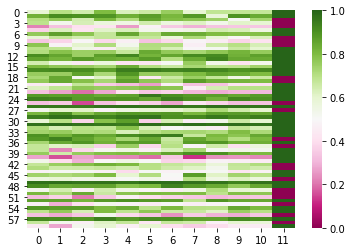

In [99]:
import seaborn as sns

sns.heatmap(labelled_scores_mean,cmap="PiYG")

0.65
[[ 6  6]
 [15 33]]


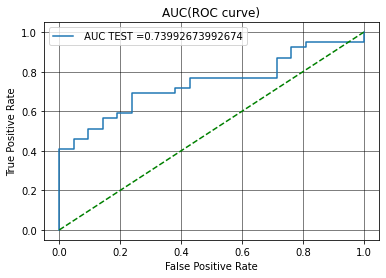

In [100]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,labelled_scores_mean[:,-2])

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y, acc))
print(confusion_matrix(acc, y, labels = [0,1]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

0.7166666666666667
[[16 12]
 [ 5 27]]


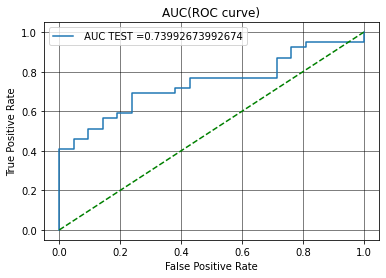

In [101]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,labelled_scores_mean[:,-2])

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.67 else acc.append(1)

print(accuracy_score(y, acc))
print(confusion_matrix(acc, y, labels = [0,1]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [102]:
X.index

Index(['MBN_84B', 'MBN_39B', 'MBN_50B', 'MBN_76B', 'MBN_85B', 'MBN_40B',
       'MBN_88B', 'MBN_9B', 'MBN_54B', 'MBN_45B', 'MBN_8B', 'MBN_71B',
       'MBN_26B', 'MBN_80B', 'MBN_86B', 'MBN_68B', 'MBN_95B', 'MBN_77B',
       'MBN_70B', 'MBN_61B', 'MBN_6B', 'MBN_15B', 'MBN_33B', 'MBN_60B',
       'MBN_24B', 'MBN_47B', 'MBN_20B', 'MBN_29B', 'MBN_55B', 'MBN_19B',
       'MBN_28B', 'MBN_82B', 'MBN_67B', 'MBN_49B', 'MBN_58B', 'MBN_42B',
       'MBN_5B', 'MBN_59B', 'MBN_41B', 'MBN_23B', 'MBN_1B', 'MBN_89B',
       'MBN_91B', 'MBN_11B', 'MBN_72B', 'MBN_18B', 'MBN_2B', 'MBN_63B',
       'MBN_78B', 'MBN_17B', 'MBN_62B', 'MBN_44B', 'MBN_34B', 'MBN_79B',
       'MBN_16B', 'MBN_25B', 'MBN_93B', 'MBN_30B', 'MBN_31B', 'MBN_65B'],
      dtype='object')

In [103]:
matched = ["MBN_5B","MBN_41B","MBN_1B","MBN_17B","MBN_44B","MBN_2B","MBN_11B","MBN_31B",
           "MBN_47B","MBN_42B","MBN_8B","MBN_20B","MBN_25B","MBN_26B","MBN_6B","MBN_16B",
           "MBN_18B","MBN_23B","MBN_28B","MBN_39B"]

y_common = y.loc[matched]

matched_scores = np.zeros((20,12))

for row,label in zip(labelled_scores_mean,y.index):
    if label in matched:
        k = 0
        for entry in row:
            matched_scores[matched.index(label)][k] = entry
            k += 1

0.65


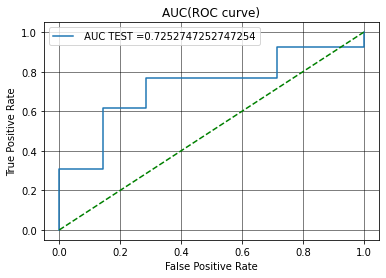

In [104]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,matched_scores[:,-2])

plt.grid()

acc = []
for val in matched_scores[:,-2]:
    acc.append(0) if val < 0.6 else acc.append(1)

print(accuracy_score(y_common, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [105]:
matched_scores

array([[0.73033001, 0.84415059, 0.8942849 , 0.82513056, 0.87322902,
        0.87630362, 0.68374002, 0.87861966, 0.88684168, 0.82531117,
        0.83179412, 1.        ],
       [0.6734029 , 0.22369169, 0.38501744, 0.51838213, 0.55142053,
        0.46754635, 0.62778155, 0.72628171, 0.5089391 , 0.54215486,
        0.52246183, 1.        ],
       [0.27060352, 0.15983677, 0.26964023, 0.22726335, 0.22473105,
        0.18841617, 0.33605632, 0.1226875 , 0.24082334, 0.24805269,
        0.22881109, 1.        ],
       [0.52421763, 0.64051164, 0.47620482, 0.64110777, 0.54290843,
        0.48979858, 0.46364656, 0.5486575 , 0.71231309, 0.58716051,
        0.56265265, 0.        ],
       [0.31999199, 0.36357448, 0.21076896, 0.33850238, 0.46197828,
        0.39312782, 0.36715858, 0.33999923, 0.30487849, 0.32935536,
        0.34293356, 0.        ],
       [0.56474532, 0.58234803, 0.54042304, 0.53895902, 0.50442879,
        0.54205958, 0.49004243, 0.70103401, 0.54997413, 0.61887598,
        0.56328903,

In [106]:
def occ(scores,thresh):
    
    occ = []

    for row in scores[:,:-2]:
        k = 0
        for item in row:
            if item >= thresh: k+=1
            
        occ.append(k/10)
        
    return occ

In [107]:
occ_oral = occ(matched_scores,0.67)

0.7


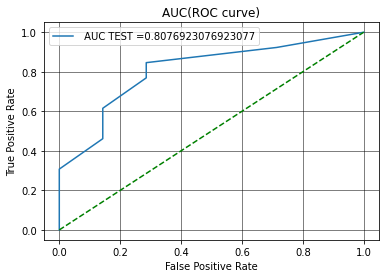

In [108]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,occ_oral)

plt.grid()

acc = []
for val in occ_oral:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_common, acc))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

0.65
[[ 6  6]
 [15 33]]


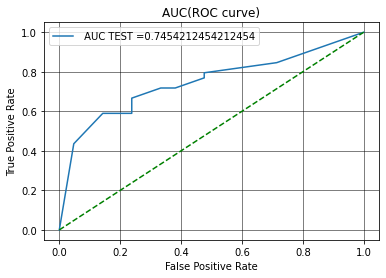

In [109]:
occ_stool_all = occ(labelled_scores_mean,0.67)

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,occ_stool_all)

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y, acc))
print(confusion_matrix(acc, y, labels = [0,1]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [496]:
lefse_stool = [["s__Alistipes_onderdonkii",2.059,0.039],["f__Clostridiaceae",3.235,0.032],["c__Coriobacteriia",3.675,0.04],["g__Lachnospira",3.500,0.028],["s__Roseburia_hominis",3.220,0.044],["f__Lachnospiraceae",4.351,0.040],["g__Actinomyces",2.477,0.024],["s__Ruminococcus_bicirculans",3.426,0.027],["g__Butyricicoccus",2.856,0.016]]

In [497]:
lefse_oral = []

In [118]:
pd_arr = pd.DataFrame(arr)

In [119]:
pd_arr

0                         1     2
0   678      s__Roseburia_hominis  Poor
1   735     c__Betaproteobacteria  Good
2  2659            g__Lachnospira  Poor
3  1820      s__Bacteroides_dorei  Poor
4   939          f__Rikenellaceae  Poor
5  2149         c__Coriobacteriia  Poor
6   815        f__Lachnospiraceae  Poor
7  2174         f__Clostridiaceae  Poor
8  2827      s__Coprococcus_comes  Good
9  2565  s__Bacteroides_uniformis  Good

In [122]:
labels={"1": "Important taxa","0": "Light Gradient Boosting Machine Feature importances","2":"Elevated in"}

In [126]:
pd_arr["LefSe"] = ["3.220","Not in LefSe","3.495","Not in LefSe","Not in LefSe",
                  "3.675","4.351","3.235","Not in LefSe","Not in LefSe"]

In [130]:
#pd_arr = pd.DataFrame(lefse_stool)

import plotly.express as px
fig = px.bar(pd_arr,x=0,y=1,color=2,labels=labels,text="LefSe",title="Stool feature importances")
fig.update_layout(yaxis_categoryorder = 'total ascending')
fig.show()

In [131]:
print(pd_arr)

      0                            1
0   687                  g__Gemmiger
1   729        c__Betaproteobacteria
2  1175  s__Ruminococcus_bicirculans
3   854             f__Rikenellaceae
4  1878         s__Bacteroides_dorei
5  1984            f__Clostridiaceae
6  1991            c__Coriobacteriia
7  2497     s__Bacteroides_uniformis
8  2574               g__Lachnospira
9  2712         s__Coprococcus_comes


In [430]:
c = ["Poor","Good","Poor","Poor","Poor","Poor","Poor","Poor","Good","Good"]

In [171]:
y[X.loc[:,"g__Butyricicoccus"]>0].value_counts()

0    3
Name: Response, dtype: int64

In [155]:
ratio = X.loc[:,"p__Firmicutes"]/X.loc[:,"p__Bacteroidetes"]

In [160]:
response

['Good',
 'Good',
 'Poor',
 'Poor',
 'Poor',
 'Good',
 'Good',
 'Poor',
 'Poor',
 'Poor',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Poor',
 'Poor',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Poor',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Poor',
 'Good',
 'Good',
 'Good',
 'Good',
 'Poor',
 'Poor',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Good',
 'Poor',
 'Poor',
 'Poor',
 'Good',
 'Poor',
 'Good',
 'Good',
 'Poor',
 'Good',
 'Poor',
 'Good']

In [177]:
import plotly.express as px

labels={"index": "Patients","value": "Relative microbial abundance (%)","color":"Elevated in"}
cg = "f__Lachnospiraceae"

X_good = X[y==1]
X_poor = X[y==0]
X_re = X.iloc[np.arange(-2, len(X)-2)]
y_re = y.iloc[np.arange(-2, len(y)-2)]

response = []
for val in y_re:
    r = "Good" if val == 1 else "Poor"
    response.append(r)

print("Good mean: " + str(np.mean(X_good.loc[:,cg])))
print("Poor mean: " + str(np.mean(X_poor.loc[:,cg])))
print("Good median: " + str(np.median(X_good.loc[:,cg])))
print("Poor median: " + str(np.median(X_poor.loc[:,cg])))

px.bar(X_re.loc[:,cg],color=response,color_discrete_sequence=px.colors.qualitative.G10,
       title="Lachnospiraceae",labels=labels)

Good mean: 10.286740769230768
Poor mean: 15.120683333333332
Good median: 7.67048
Poor median: 12.78342


In [176]:
matched = ["MBN_5B","MBN_41B","MBN_1B","MBN_17B","MBN_44B","MBN_2B","MBN_11B","MBN_31B",
           "MBN_47B","MBN_42B","MBN_8B","MBN_20B","MBN_25B","MBN_26B","MBN_6B","MBN_16B",
           "MBN_18B","MBN_23B","MBN_28B","MBN_39B"]

X_matched = X.loc[matched,:]

y_common = y.loc[matched]

response_matched = []
for val in y_common:
    r = "Good" if val == 1 else "Poor"
    response_matched.append(r)

import plotly.express as px

labels={"index": "Patients","value": "Relative microbial abundance (%)","color":"Elevated in"}
cg = "f__Clostridiaceae"

X_good = X_matched[y==1]
X_poor = X_matched[y==0]
print("Good mean: " + str(np.mean(X_good.loc[:,cg])))
print("Poor mean: " + str(np.mean(X_poor.loc[:,cg])))
print("Good median: " + str(np.median(X_good.loc[:,cg])))
print("Poor median: " + str(np.median(X_poor.loc[:,cg])))

px.bar(X_matched.loc[:,cg],color=response_matched,color_discrete_sequence=px.colors.qualitative.G10,
       title="Lachnospiraceae",labels=labels)

Good mean: 0.3929023076923077
Poor mean: 0.6043142857142857
Good median: 0.25353
Poor median: 0.43642


<AxesSubplot:>

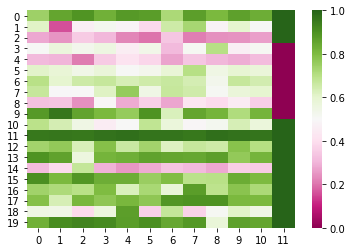

In [134]:
sns.heatmap(matched_scores,cmap="PiYG",center=0.5)

In [135]:
matched_scores

array([[0.74333924, 0.85330064, 0.8942849 , 0.82513056, 0.87894681,
        0.87344459, 0.71875419, 0.87106008, 0.80726201, 0.86339071,
        0.83289137, 1.        ],
       [0.6093922 , 0.16011601, 0.45782177, 0.5204178 , 0.48275064,
        0.38523689, 0.65280436, 0.72692943, 0.47679465, 0.59836393,
        0.50706277, 1.        ],
       [0.27842885, 0.24717215, 0.348076  , 0.30533762, 0.22473105,
        0.19598819, 0.33605632, 0.21220077, 0.24082334, 0.24575562,
        0.26345699, 1.        ],
       [0.50605947, 0.56792704, 0.52754783, 0.55570582, 0.45553971,
        0.53830576, 0.30909261, 0.51457432, 0.69926983, 0.45952139,
        0.51335438, 0.        ],
       [0.30972962, 0.29717316, 0.21076896, 0.34954747, 0.41015645,
        0.37509615, 0.27091424, 0.33897139, 0.30290611, 0.2863036 ,
        0.31515671, 0.        ],
       [0.60800308, 0.58234803, 0.54042304, 0.57617175, 0.50442879,
        0.52356625, 0.58279166, 0.70103401, 0.54997413, 0.59146333,
        0.57602041,

In [28]:
from sklearn import svm
import shap

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X,y)

svm_explainer = shap.KernelExplainer(model.predict,X)
svm_shap_values = svm_explainer.shap_values(X)

  0%|          | 0/61 [00:00<?, ?it/s]

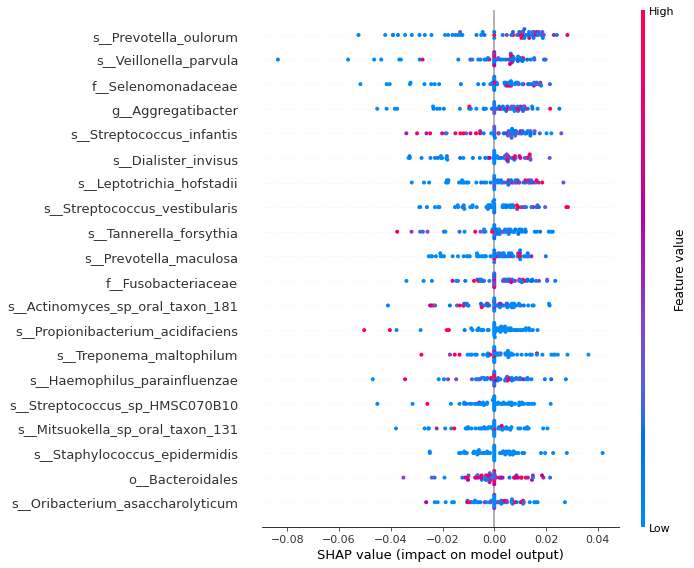

In [29]:
shap.summary_plot(svm_shap_values, X)

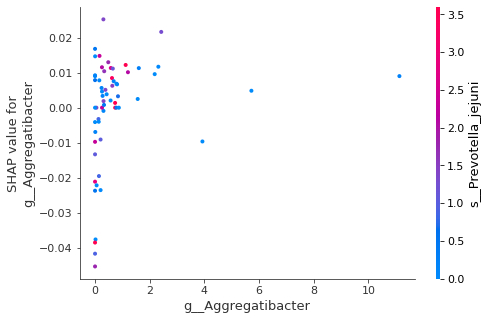

In [31]:
shap.dependence_plot("g__Aggregatibacter", svm_shap_values, X)

In [32]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values[-1,:], X.iloc[-1,:])

In [3]:
import xgboost as xgb
import shap

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,stratify=y,random_state=1)

model = xgb.XGBClassifier()
model.fit(X, y)

[10:19:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [4]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


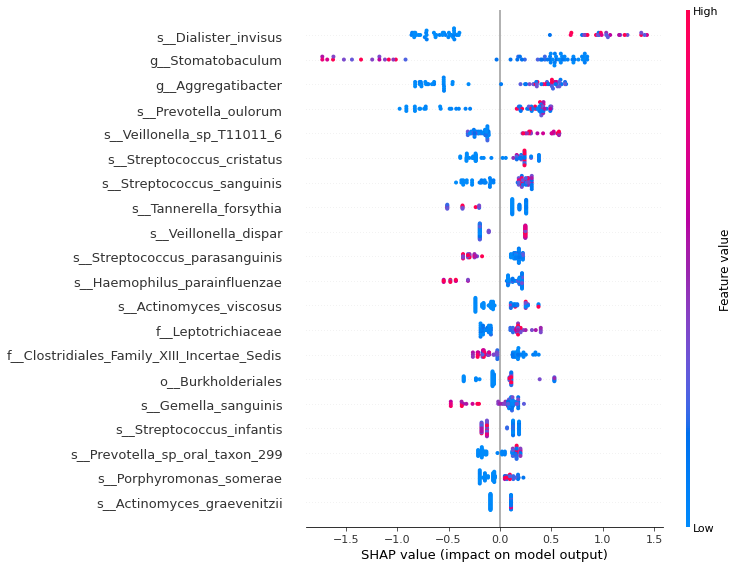

In [5]:
shap.summary_plot(shap_values, X)

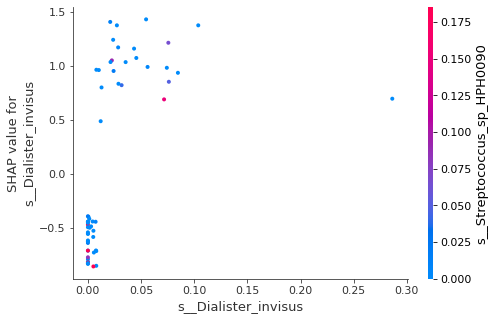

In [6]:
shap.dependence_plot("s__Dialister_invisus", shap_values.values, X)

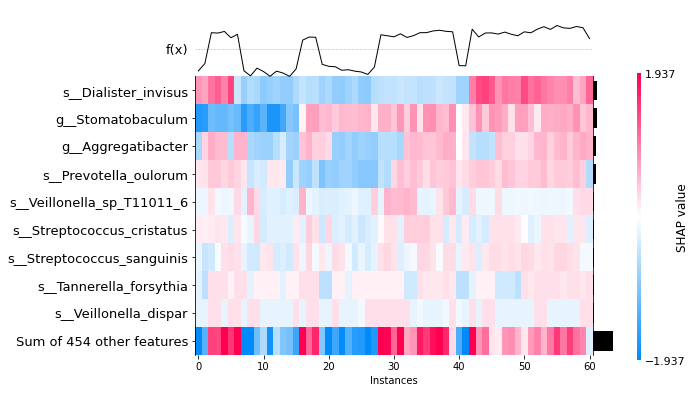

In [7]:
shap.plots.heatmap(shap_values)

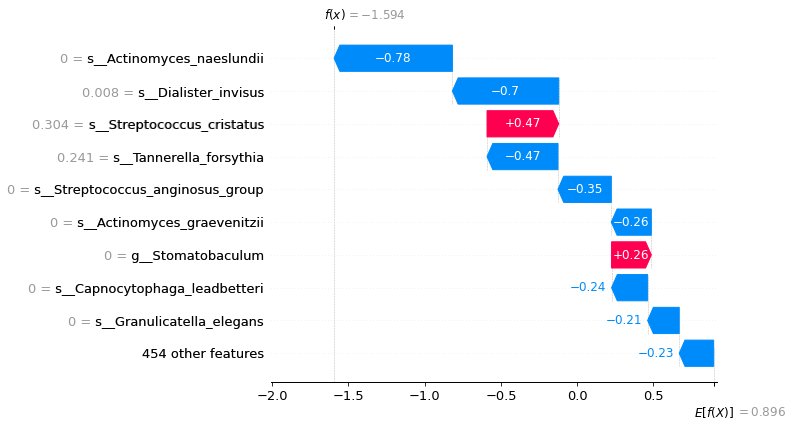

In [162]:
shap.plots.waterfall(shap_values[6])

In [154]:
shap.force_plot(shap_values[2])

In [152]:
y_test

MBN_62B_O    0
MBN_89B_O    1
MBN_45B_O    0
MBN_44B_O    0
MBN_1B_O     1
MBN_88B_O    1
MBN_24B_O    1
Name: Response, dtype: int64

[0.15618429 0.13810494 0.2216837  0.03615442 0.14322914 0.02408497
 0.05159578 0.22896276]


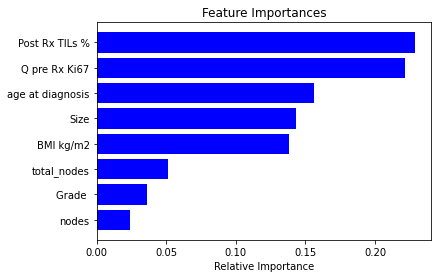

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

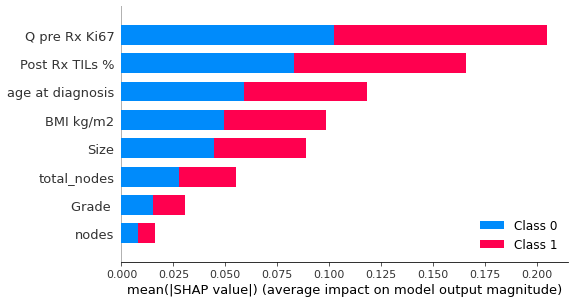

In [67]:
import shap

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

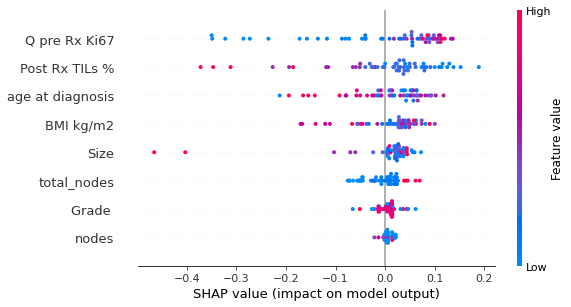

In [68]:
shap.summary_plot(shap_values[1], X_train, plot_type="dot")

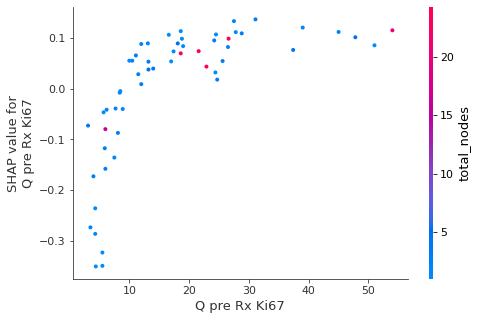

In [69]:
shap.dependence_plot("Q pre Rx Ki67", shap_values[1], X_train)

In [82]:
shap.initjs()
rf_explainer = shap.KernelExplainer(rf.predict, X_train)
rf_shap_values = rf_explainer.shap_values(X_train)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/56 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

In [85]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values[-1,:], X_train.iloc[-1,:])

In [86]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_train)